In [1]:
%matplotlib widget

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt

from tqdm import tqdm

from pyinverse.axis import RegularAxis
from pyinverse.grid import RegularGrid
from pyinverse.axes import RegularAxes3
from pyinverse.phantom3 import Phantom3

from pyviz3d.viz import Renderer

In [3]:
#Nx = 46
#Ny = 47
#Nz = 48
# Nx = 127
# Ny = 128
# Nz = 129
Nx = 255
Ny = 256
Nz = 257
axes3 = RegularAxes3.linspace((-1, 1, Nx), (-1, 1, Ny), (-1, 1, Nz))

In [4]:
Nu = 512
Nv = 513
#grid_uv = RegularGrid.linspace((-1.5, 1.5, Nu), (-1.5, 1.5, Nv))
grid_uv = RegularGrid.linspace((-2, 2, Nu), (-2, 2, Nv))

In [5]:
theta_deg = 0
# trivial geometry (via Clack 1992) is with theta = 0
assert theta_deg == 0

phi_deg = 0
phi_rad = np.radians(phi_deg)

In [6]:
p3 = Phantom3()

In [7]:
p_uv = p3.proj(theta_deg, phi_deg, grid_uv, deg=True)

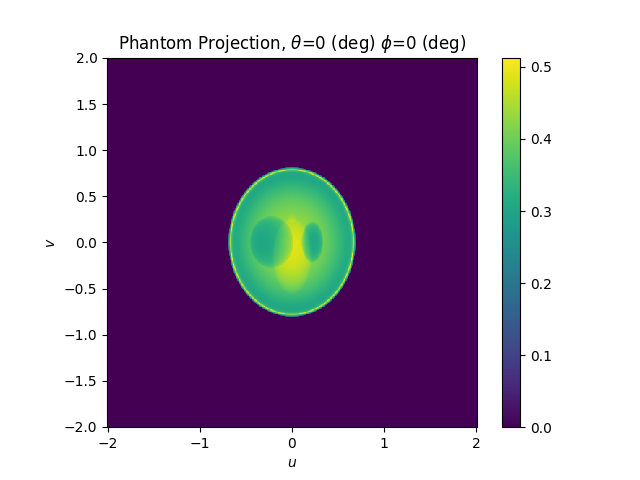

In [8]:
fig, ax = plt.subplots()
im = grid_uv.plot(ax, p_uv)
ax.set_xlabel(f'$u$')
ax.set_ylabel(f'$v$')
ax.set_title(f'Phantom Projection, $\\theta$={theta_deg} (deg) $\phi$={phi_deg} (deg)')
plt.colorbar(im, ax=ax);

In [9]:
grid_uv_ft, p_uv_ft = grid_uv.spectrum(p_uv)
grid_uv_ft

<FreqRegularGrid <axis_x: <FFTRegularAxis x0=-401.3384614960961 T=1.5677283652191254 N=512>> <axis_y: <FFTRegularAxis x0=-401.339992486668 T=1.5677343456510469 N=513>>>

In [10]:
grid_uv_ft_Hz = grid_uv_ft.Hz()
grid_uv_ft_Hz

<RegularGrid <axis_x: <FFTRegularAxis x0=-63.875 T=0.24951171875 N=512>> <axis_y: <FFTRegularAxis x0=-63.875243664717345 T=0.24951267056530213 N=513>>>

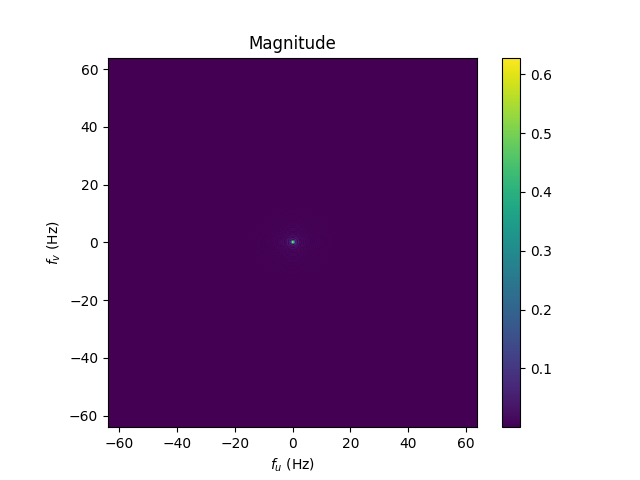

In [11]:
fig, ax = plt.subplots()
im = grid_uv_ft_Hz.plot(ax, np.abs(p_uv_ft))
ax.set_xlabel(f'$f_u$ (Hz)')
ax.set_ylabel(f'$f_v$ (Hz)')
ax.set_title('Magnitude')
plt.colorbar(im, ax=ax);

In [12]:
Cu_Hz, Cv_Hz = grid_uv_ft_Hz.centers
ramp = np.sqrt(Cu_Hz**2 + Cv_Hz**2)

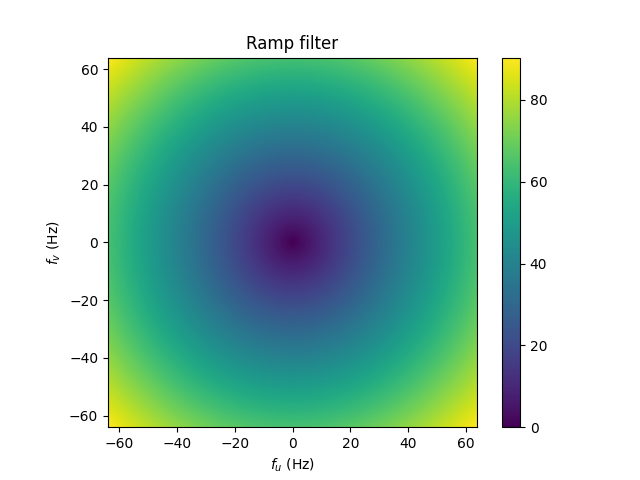

In [13]:
fig, ax = plt.subplots()
im = grid_uv_ft_Hz.plot(ax, ramp)
ax.set_xlabel(f'$f_u$ (Hz)')
ax.set_ylabel(f'$f_v$ (Hz)')
ax.set_title('Ramp filter')
plt.colorbar(im, ax=ax);

In [14]:
p_uv_ft_ramp = p_uv_ft * ramp

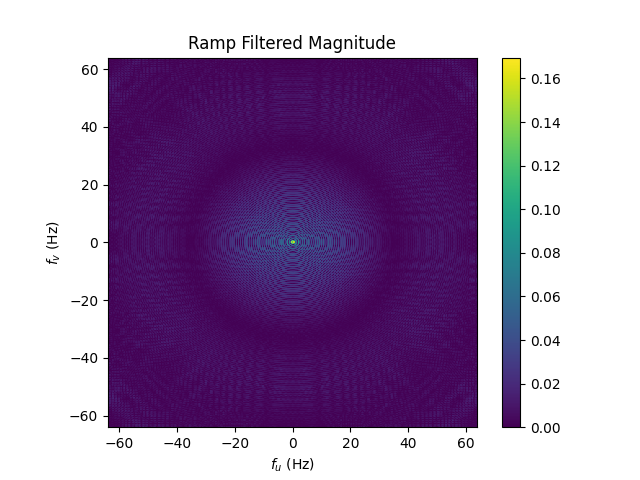

In [15]:
fig, ax = plt.subplots()
im = grid_uv_ft_Hz.plot(ax, np.abs(p_uv_ft_ramp))
ax.set_xlabel(f'$f_u$ (Hz)')
ax.set_ylabel(f'$f_v$ (Hz)')
ax.set_title('Ramp Filtered Magnitude')
plt.colorbar(im, ax=ax);

In [16]:
check, p_uv_filtered = grid_uv_ft.ispectrum(p_uv_ft_ramp)
check, grid_uv

(<RegularGrid <axis_x: <RegularAxis x0=-2 T=0.007827788649706457 N=512>> <axis_y: <RegularAxis x0=-2 T=0.0078125 N=513>>>,
 <RegularGrid <axis_x: <RegularAxis x0=-2 T=0.007827788649706457 N=512>> <axis_y: <RegularAxis x0=-2 T=0.0078125 N=513>>>)

In [17]:
assert np.allclose(np.imag(p_uv_filtered), 0)
p_uv_filtered = np.real(p_uv_filtered)

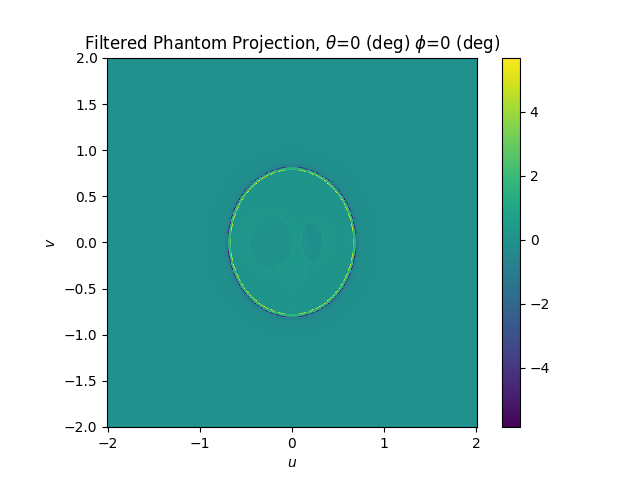

In [18]:
fig, ax = plt.subplots()
im = grid_uv.plot(ax, p_uv_filtered)
ax.set_xlabel(f'$u$')
ax.set_ylabel(f'$v$')
ax.set_title(f'Filtered Phantom Projection, $\\theta$={theta_deg} (deg) $\phi$={phi_deg} (deg)')
plt.colorbar(im, ax=ax);

In [19]:
def backproject(theta, phi, axes3, grid_uv, X, method='linear', degrees=False):
    if degrees:
        theta_rad = np.radians(theta)
        phi_rad = np.radians(phi)
    else:
        theta_rad = theta
        phi_rad = phi
    c_z, c_y, c_x = axes3.centers

    c_phi = np.cos(phi_rad)
    s_phi = np.sin(phi_rad)
    
    c_theta = np.cos(theta_rad)
    s_theta = np.sin(theta_rad)
    
    e1 = np.array([c_phi, s_phi, 0])
    e2 = np.array([s_phi * s_theta, -c_phi * s_theta, c_theta])
    
    p_xyz = np.array([c_x, c_y, c_z])
    e12 = np.array([e1, e2])

    uv_backproject = np.einsum('ij,jklm->iklm', e12, p_xyz)
    
    u_backproject = uv_backproject[0, :, :, :]
    v_backproject = uv_backproject[1, :, :, :]
    
    interp2d = sp.interpolate.RegularGridInterpolator((grid_uv.axis_y.centers, grid_uv.axis_x.centers), X, method=method, bounds_error=True)
    
    X_backproject = interp2d(np.array([v_backproject.flatten(), u_backproject.flatten()]).T)
    X_backproject.shape = axes3.shape
    
    return X_backproject

In [20]:
X_backproject = backproject(theta_deg, phi_deg, axes3, grid_uv, p_uv_filtered, degrees=True)

In [21]:
X_backproject_actor = axes3.actor(X_backproject)
#X_backproject_actor.GetProperty().SetOpacity(0.5)

In [22]:
ren = Renderer()
ren.add_actor(X_backproject_actor)
#ren.axes_on((-1, 1, -1, 1, -1, 1))
ren.axes_on((-1.5, 1.5, -1.5, 1.5, -1.5, 1.5))
ren.reset_camera()
#ren.start()

In [23]:
N_phi = 256
phi_deg_axis = RegularAxis.linspace(0, 180, N_phi, endpoint=False)

In [24]:
X_backproject = np.zeros(axes3.shape)

In [25]:
for phi_deg_i in tqdm(phi_deg_axis):
    p_uv_i = p3.proj(theta_deg, phi_deg_i, grid_uv, deg=True)
    
    grid_uv_ft_i, p_uv_ft_i = grid_uv.spectrum(p_uv_i)
    p_uv_ft_ramp_i = p_uv_ft_i * ramp
    
    _, p_uv_filtered_i = grid_uv_ft.ispectrum(p_uv_ft_ramp_i)
    
    assert np.allclose(np.imag(p_uv_filtered_i), 0)
    p_uv_filtered_i = np.real(p_uv_filtered_i)

    X_backproject += backproject(theta_deg, phi_deg_i, axes3, grid_uv, p_uv_filtered_i, degrees=True)
X_backproject *= np.radians(phi_deg_axis.T)

100%|█████████████████████████████████████████████████████████████████████████████████| 256/256 [04:14<00:00,  1.01it/s]


In [26]:
c_z, c_y, c_x = axes3.centers
p_xyz = np.array([c_x, c_y, c_z])

X_p3 = p3(*p_xyz.reshape(3, Nx * Ny * Nz))
X_p3.shape = axes3.shape

In [27]:
k_mid = Nz // 2
grid_xy = RegularGrid(axes3.axis_x, axes3.axis_y)

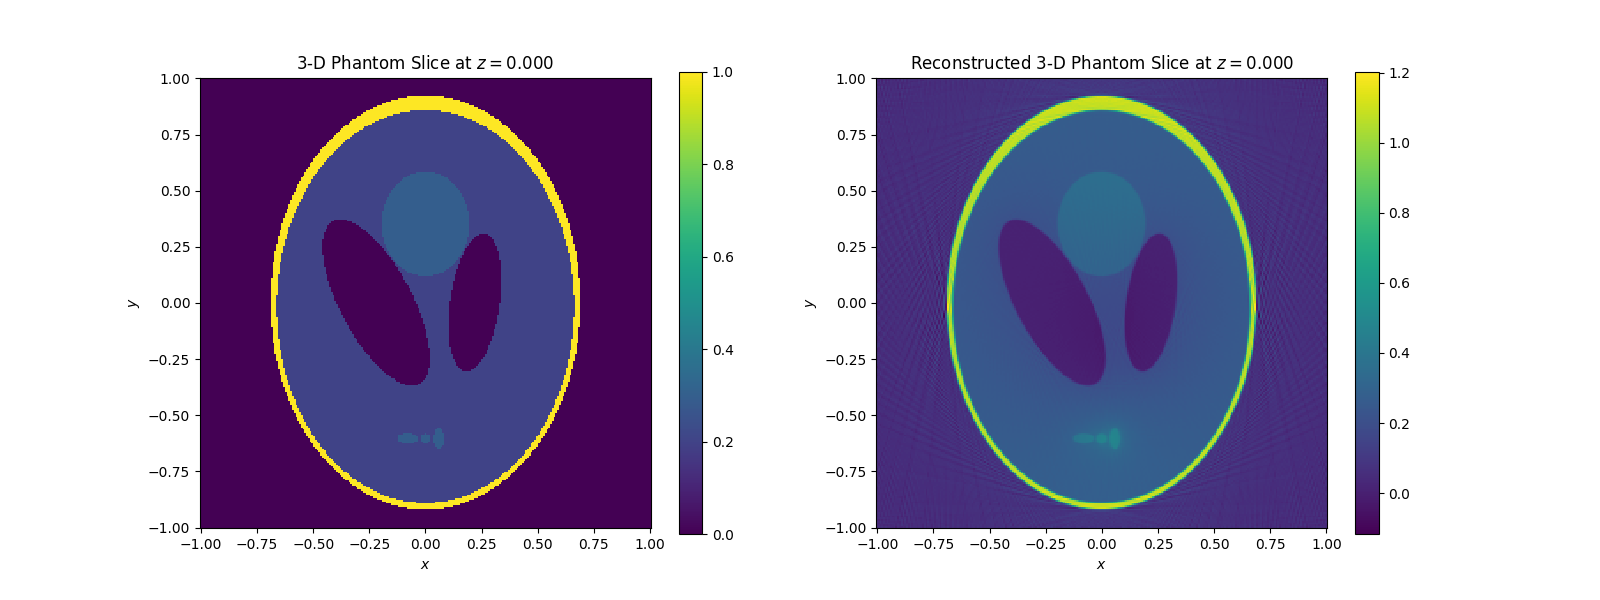

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
im0 = grid_xy.plot(ax[0], X_p3[k_mid, :, :])
ax[0].set_xlabel(f'$x$')
ax[0].set_ylabel(f'$y$')
ax[0].set_title(f'3-D Phantom Slice at $z=${axes3.axis_z[k_mid]:.3f}')
plt.colorbar(im0, ax=ax[0])
im1 = grid_xy.plot(ax[1], X_backproject[k_mid, :, :])
ax[1].set_xlabel(f'$x$')
ax[1].set_ylabel(f'$y$')
ax[1].set_title(f'Reconstructed 3-D Phantom Slice at $z=${axes3.axis_z[k_mid]:.3f}')
plt.colorbar(im1, ax=ax[1]);

In [29]:
j_mid = Ny // 2
grid_xz = RegularGrid(axes3.axis_x, axes3.axis_z)

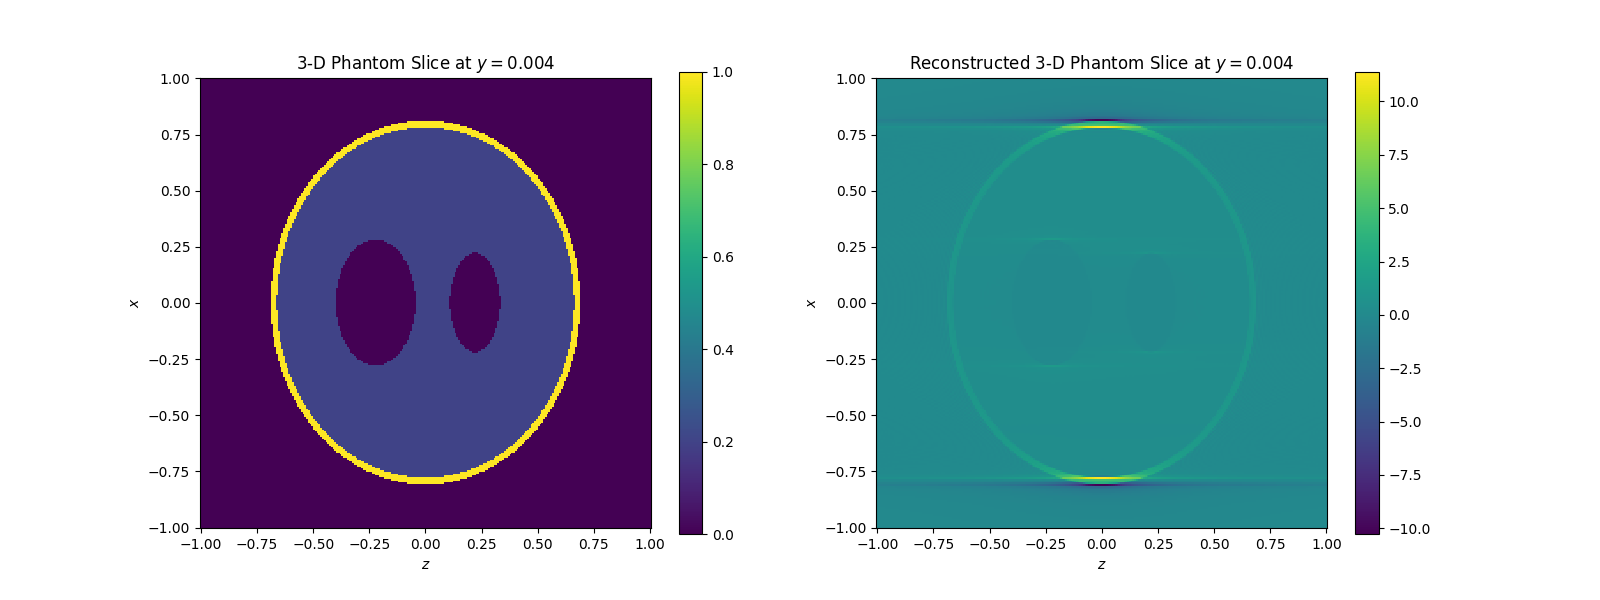

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
im0 = grid_xz.plot(ax[0], X_p3[:, j_mid, :])
ax[0].set_xlabel(f'$z$')
ax[0].set_ylabel(f'$x$')
ax[0].set_title(f'3-D Phantom Slice at $y=${axes3.axis_y[j_mid]:.3f}')
plt.colorbar(im0, ax=ax[0])
im1 = grid_xz.plot(ax[1], X_backproject[:, j_mid, :])
ax[1].set_xlabel(f'$z$')
ax[1].set_ylabel(f'$x$')
ax[1].set_title(f'Reconstructed 3-D Phantom Slice at $y=${axes3.axis_y[j_mid]:.3f}')
plt.colorbar(im1, ax=ax[1]);

In [31]:
i_mid = Nx // 2
grid_zy = RegularGrid(axes3.axis_y, axes3.axis_z)

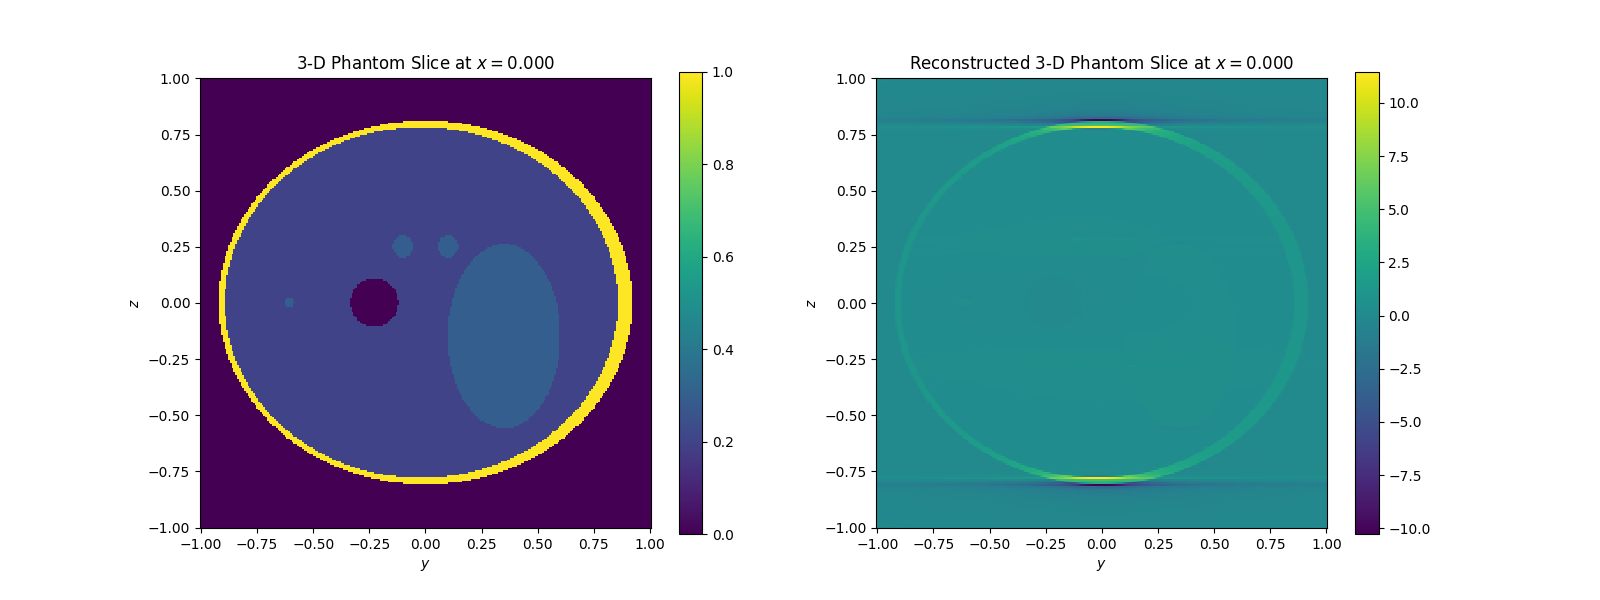

In [32]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
im0 = grid_zy.plot(ax[0], X_p3[:, :, i_mid])
ax[0].set_xlabel(f'$y$')
ax[0].set_ylabel(f'$z$')
ax[0].set_title(f'3-D Phantom Slice at $x=${axes3.axis_x[i_mid]:.3f}')
plt.colorbar(im0, ax=ax[0])
im1 = grid_zy.plot(ax[1], X_backproject[:, :, i_mid])
ax[1].set_xlabel(f'$y$')
ax[1].set_ylabel(f'$z$')
ax[1].set_title(f'Reconstructed 3-D Phantom Slice at $x=${axes3.axis_x[i_mid]:.3f}')
plt.colorbar(im1, ax=ax[1]);

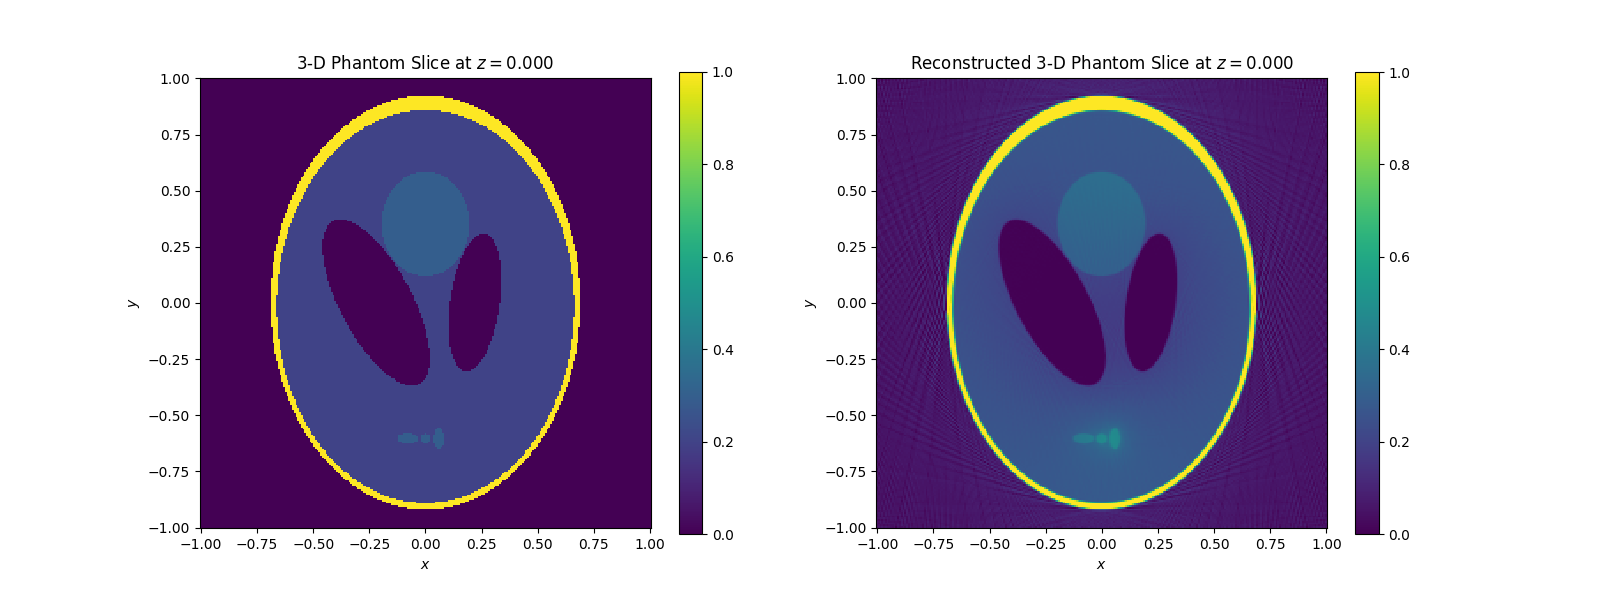

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
im0 = grid_xy.plot(ax[0], X_p3[k_mid, :, :])
ax[0].set_xlabel(f'$x$')
ax[0].set_ylabel(f'$y$')
ax[0].set_title(f'3-D Phantom Slice at $z=${axes3.axis_z[k_mid]:.3f}')
plt.colorbar(im0, ax=ax[0])
im1 = grid_xy.plot(ax[1], X_backproject[k_mid, :, :], vmin=0, vmax=1)
ax[1].set_xlabel(f'$x$')
ax[1].set_ylabel(f'$y$')
ax[1].set_title(f'Reconstructed 3-D Phantom Slice at $z=${axes3.axis_z[k_mid]:.3f}')
plt.colorbar(im1, ax=ax[1]);

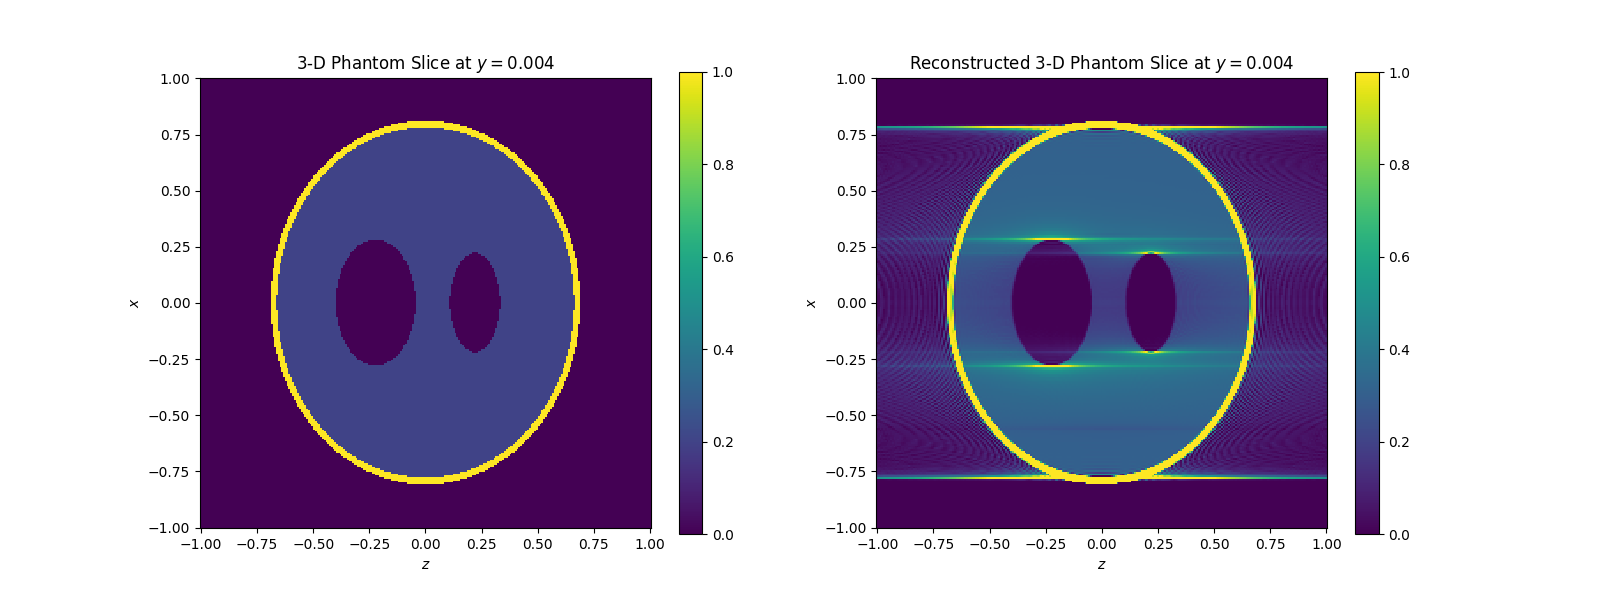

In [34]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
im0 = grid_xz.plot(ax[0], X_p3[:, j_mid, :])
ax[0].set_xlabel(f'$z$')
ax[0].set_ylabel(f'$x$')
ax[0].set_title(f'3-D Phantom Slice at $y=${axes3.axis_y[j_mid]:.3f}')
plt.colorbar(im0, ax=ax[0])
im1 = grid_xz.plot(ax[1], X_backproject[:, j_mid, :], vmin=0, vmax=1)
ax[1].set_xlabel(f'$z$')
ax[1].set_ylabel(f'$x$')
ax[1].set_title(f'Reconstructed 3-D Phantom Slice at $y=${axes3.axis_y[j_mid]:.3f}')
plt.colorbar(im1, ax=ax[1]);

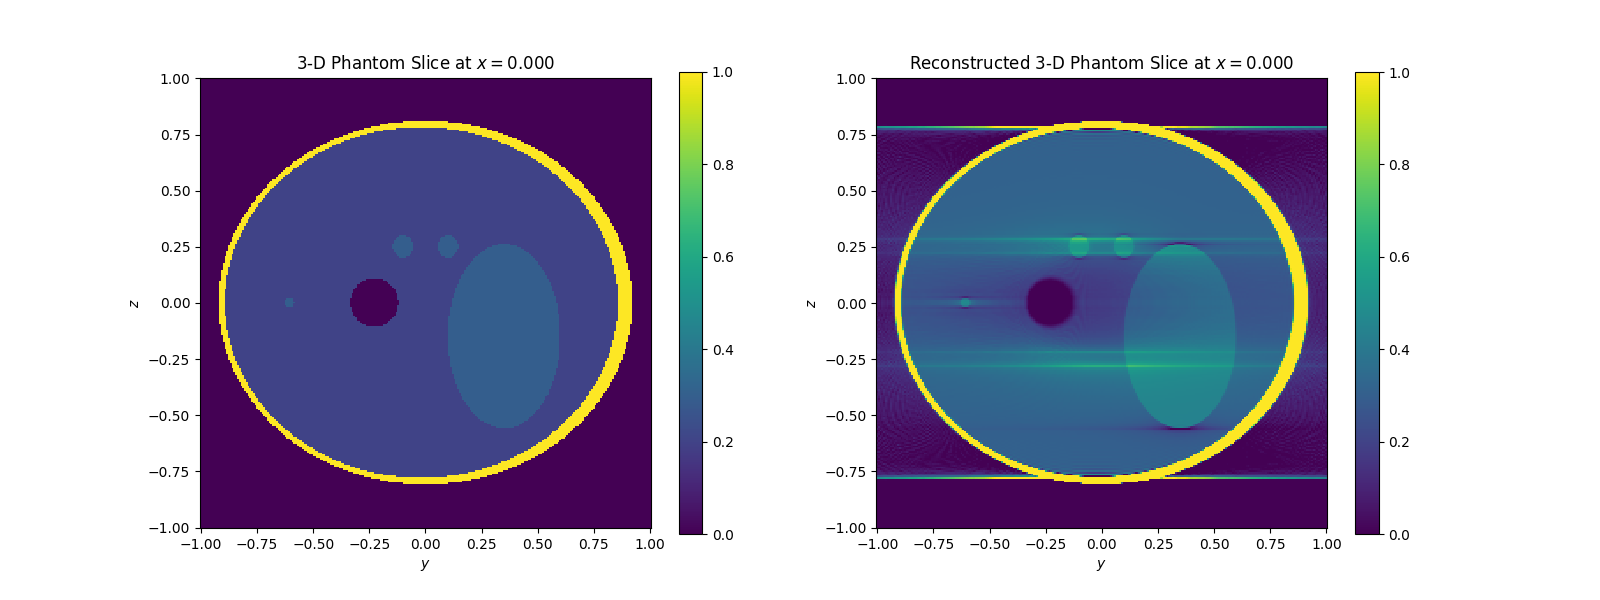

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
im0 = grid_zy.plot(ax[0], X_p3[:, :, i_mid])
ax[0].set_xlabel(f'$y$')
ax[0].set_ylabel(f'$z$')
ax[0].set_title(f'3-D Phantom Slice at $x=${axes3.axis_x[i_mid]:.3f}')
plt.colorbar(im0, ax=ax[0])
im1 = grid_zy.plot(ax[1], X_backproject[:, :, i_mid], vmin=0, vmax=1)
ax[1].set_xlabel(f'$y$')
ax[1].set_ylabel(f'$z$')
ax[1].set_title(f'Reconstructed 3-D Phantom Slice at $x=${axes3.axis_x[i_mid]:.3f}')
plt.colorbar(im1, ax=ax[1]);